# Clasificación de imágenes de biopsias de colon

Este documento muestra cómo entrenar y evaluar un modelo de clasificación binaria para imágenes de biopsias, distinguiendo entre benigno y maligno. Para ello usa el dataset [EBHI](https://www.kaggle.com/datasets/orvile/ebhi-seg-colorectal-cancer).

## Preparación del Entorno

Primero, cargamos las librerías necesarias y configuramos el dispositivo de cómputo (GPU si está disponible).

Si tienes GPU, el proceso será mucho más rápido.

In [2]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoFeatureExtractor
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ruta al dataset
data_dir = "/kaggle/input/ebhi-seg/EBHI-SEG"
batch_size = 32
num_workers = 4

## Carga y Preparación de Datos

Las imágenes se etiquetan como:
- 0: Benigno
- 1: Maligno

### Transformaciones aplicadas a las imágenes

Antes de usar las imágenes con el modelo, aplicamos algunas transformaciones importantes, ya que **los modelos de visión**, como DINOv3, **esperan imágenes de un tamaño específico**. Esto asegura que todas las imágenes tengan el mismo tamaño para poder procesarlas, y también **esperan que los valores de los píxeles estén en un rango estándar.**

Esto ayuda al modelo a **aprender** y a **comparar** imágenes de manera **más consistente.**

### Conjuntos de Datos

Dividimos las imágenes en **dos conjuntos:**

- Dataset de **entrenamiento** (80% de las imágenes): Se usa para extraer las features que representan cada imagen. **El modelo aprende las características típicas** de imágenes benignas y malignas de este conjunto.
- Dataset de **validación** (20% de las imágenes). Se usa para **evaluar la precisión del modelo** en imágenes que nunca ha visto antes. Esto nos permite medir qué tan bien generaliza a datos nuevos.

En resumen: **el entrenamiento sirve para “enseñar”** al modelo, y **la validación sirve para comprobar si realmente aprendió.**

In [3]:
# DINOv2 espera imagenes 224x224 y normalizadas
mean = [0.5, 0.5, 0.5]  # DINOv2 usa rango [-1,1] en general, algunas versiones usan 0.5/0.5
std = [0.5, 0.5, 0.5]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1) if x.shape[0]==1 else x),
    transforms.Normalize(mean=mean, std=std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1) if x.shape[0]==1 else x),
    transforms.Normalize(mean=mean, std=std)
])


In [4]:
full_dataset = datasets.ImageFolder(root=data_dir, transform=None)
full_dataset.samples = [
    (path, label)
    for path, label in full_dataset.samples
    if "/label/" not in path.replace("\\", "/")  # compatible con Windows y Linux
]

# Crear mapeo binario
malignant_classes = {"High-grade IN", "Adenocarcinoma"}
benign_classes = set(full_dataset.classes) - malignant_classes

class_to_idx = full_dataset.class_to_idx
old_to_new = {}
for cls, idx in class_to_idx.items():
    if cls in malignant_classes:
        old_to_new[idx] = 1
    elif cls in benign_classes:
        old_to_new[idx] = 0

full_dataset.samples = [
    (path, old_to_new[label])
    for path, label in full_dataset.samples
    if label in old_to_new
]

# Dividir 80% train, 20% val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(72)
)

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")


Train: 1782, Val: 446


## Carga del Modelo Preentrenado

Para analizar las imágenes usamos **DINOv3 ViT-S16**, un modelo de visión avanzado creado por **Facebook AI Research (Meta).**

**¿Por qué usamos DINOv3?**
- Es un modelo de aprendizaje profundo preentrenado, lo que significa que **ya fue entrenado previamente con millones de imágenes.**
- **Aprendió a extraer características visuales complejas,** como formas, texturas y patrones.

Gracias a esto, podemos usar sus “conocimientos” **sin entrenar un modelo desde cero**, ahorrando tiempo y recursos.

**Cómo ayuda a nuestra tarea**

- **Cada imagen se convierte** en un vector de características (una especie de **“resumen matemático”** de la imagen).
- Estas características permiten **comparar imágenes entre sí,** facilitando la clasificación en benignas o malignas.
- Como DINOv3 ya está preentrenado, podemos **enfocarnos en utilizar sus representaciones para clasificar** las imágenes sin necesidad de entrenar una red neuronal completa.

In [6]:
#model_name = "facebook/dinov2-base"
model_name = "facebook/dinov3-vits16-pretrain-lvd1689m"
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()

def extract_features(loader):
    features_list = []
    labels_list = []
    with torch.no_grad():
        for images, labels in tqdm(loader):
            images = images.to(device)
            outputs = model(images)
            # Pooling: tomar el CLS token
            pooled = outputs.last_hidden_state[:,0]
            features_list.append(pooled.cpu())
            labels_list.append(labels)
    features = torch.cat(features_list)
    labels = torch.cat(labels_list)
    return features, labels


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

2025-09-09 17:13:27.357532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757438007.579845      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757438007.642437      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/86.4M [00:00<?, ?B/s]

## Extracción de Features

**Cada imagen se convierte en un vector** de características usando el modelo.

Estas features permiten **comparar similitudes** entre imágenes sin entrenar un clasificador complejo.

In [7]:
train_features, train_labels = extract_features(train_loader)

torch.save(train_features, "train_features.pt")
torch.save(train_labels, "train_labels.pt")

print("Features de entrenamiento guardadas")

100%|██████████| 56/56 [00:05<00:00,  9.50it/s]

Features de entrenamiento guardadas


# Reducción de Dimensionalidad y Visualización 2D

- Se aplica **PCA (Análisis de Componentes Principales)** a las features de entrenamiento para reducirlas a **2 dimensiones**.  
- Al proyectar los datos de alta dimensión a solo 2 dimensiones, **se pierden algunas dimensiones** y, por tanto, parte de la información original.  
- Se genera un **scatter plot 2D**, donde cada punto representa una muestra y se colorea según su clase.  
- Esta visualización permite observar patrones generales y cómo se separan las clases en 2D, pero **para la clasificación real se usan todas las dimensiones de las features**, por lo que el modelo puede aprovechar información que no se ve en esta proyección.


Dimensiones originales: 384


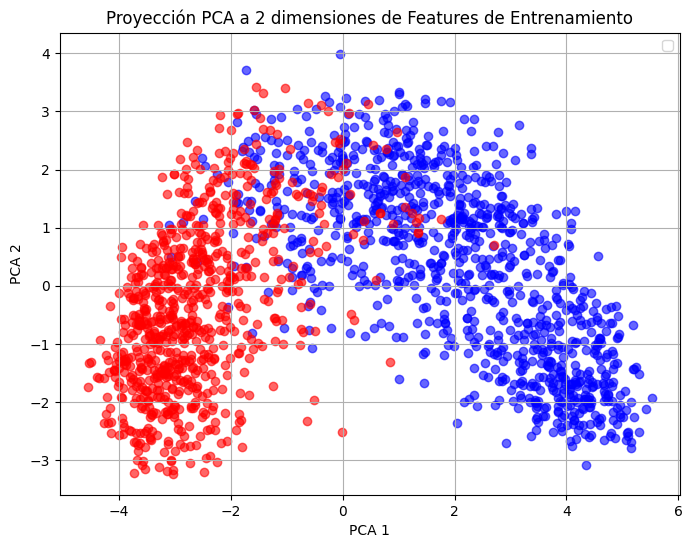

In [13]:
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Cargar las features y labels guardadas
train_features = torch.load("train_features.pt")
train_labels = torch.load("train_labels.pt")

# Convertir a numpy para sklearn
X = train_features.numpy()
y = train_labels.numpy()

print(f'Dimensiones originales: {X.shape[1]}')

# Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plotear
plt.figure(figsize=(8,6))
colors = ['blue', 'red']  # Cambia o añade colores si tienes más clases

for i, color in enumerate(colors):
    plt.scatter(X_pca[y==i, 0], X_pca[y==i, 1], c=color, alpha=0.6)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Proyección PCA a 2 dimensiones de Features de Entrenamiento')
plt.legend()
plt.grid(True)
plt.show()

## Clasificación con k-NN

Se usa un **método simple** llamado k-vecinos más cercanos (k-NN).

Para **cada imagen** de validación:
- Se **calcula la similitud con todas las imágenes de entrenamiento.**
- Se **seleccionan los 7** vecinos **más cercanos.**
- **Se asigna la clase más frecuente entre esos vecinos.**

Además, para este conjunto **se calcula el porcentaje de imágenes correctamente clasificadas.** Con esto, podemos saber como de fiable será el modelo.

In [8]:
from torch.nn.functional import cosine_similarity, softmax
import numpy as np
from tqdm import tqdm

val_features, val_labels = extract_features(val_loader)

# Separar features por clase
class0_features = train_features[train_labels==0]
class1_features = train_features[train_labels==1]

k = 7  # vecinos más cercanos

preds = []
for vf in tqdm(val_features):
    sims0 = cosine_similarity(vf.unsqueeze(0), class0_features)
    sims1 = cosine_similarity(vf.unsqueeze(0), class1_features)
    
    topk0 = sims0.topk(k).values.mean()
    topk1 = sims1.topk(k).values.mean()
    
    sims = torch.stack([topk0, topk1])
    probs = softmax(sims, dim=0)
    
    pred_class = torch.argmax(probs).item()
    preds.append(pred_class)

val_acc = (np.array(preds) == val_labels.numpy()).mean()
print(f"✅ Accuracy en validación (top {k} vecinos): {val_acc:.4f}")

100%|██████████| 446/446 [00:00<00:00, 1235.65it/s]

✅ Accuracy en validación (top 7 vecinos): 0.9753


## Matriz de Confusión

Visualizamos **errores por clase:**
- Filas: clase real
- Columnas: predicción

Colores más oscuros → más ejemplos

Clase 0: 254 ejemplos
Clase 1: 192 ejemplos


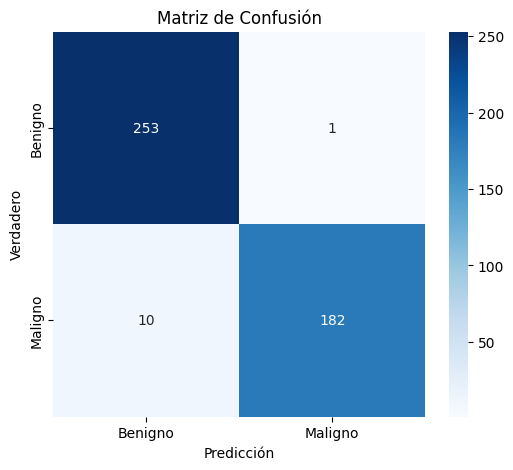

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(val_labels.numpy(), np.array(preds))

class_totals = cm.sum(axis=1)
for i, total in enumerate(class_totals):
    print(f"Clase {i}: {total} ejemplos")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()


## Ejemplos de Predicciones

Se muestran **10 imágenes de validación (5 benignas, 5 malignas) con su predicción:**
- GT = Ground Truth (verdadera)
- Pred = Predicción del modelo

Cada imagen tiene título: GT: Benigna/Maligna y Pred: Benigna/Maligna.

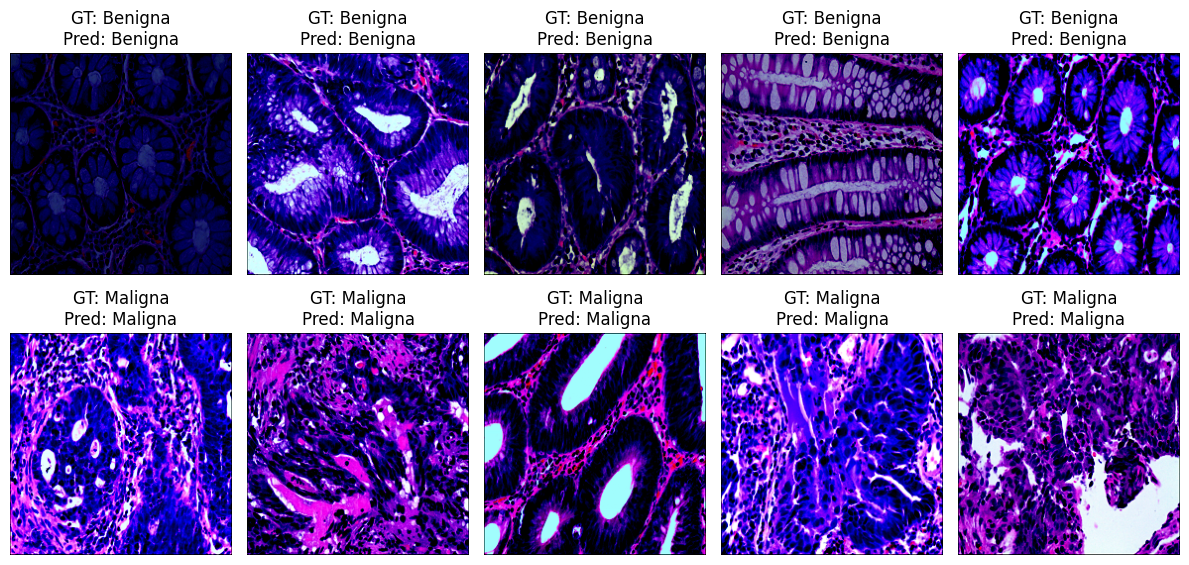

In [10]:
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import cosine_similarity, softmax
import random

val_benign = [x for x, y in val_dataset if y == 0]
val_malign = [x for x, y in val_dataset if y == 1]

sample_benign = random.sample(val_benign, 5)
sample_malign = random.sample(val_malign, 5)
samples = sample_benign + sample_malign
sample_labels = [0]*5 + [1]*5

model.eval()
model.to(device)
preds = []

for img, label in zip(samples, sample_labels):
    img_tensor = img.unsqueeze(0).to(device)  # [1,C,H,W]
    with torch.no_grad():
        emb = model(img_tensor).last_hidden_state[:,0]  # CLS token

    class0_feats = train_features[train_labels==0].to(device)
    class1_feats = train_features[train_labels==1].to(device)

    sims0 = cosine_similarity(emb, class0_feats)
    sims1 = cosine_similarity(emb, class1_feats)

    topk = 7
    topk0 = sims0.topk(topk).values.mean()
    topk1 = sims1.topk(topk).values.mean()

    prob = softmax(torch.stack([topk0, topk1]), dim=0)
    pred_class = torch.argmax(prob).item()
    preds.append(pred_class)

plt.figure(figsize=(12,6))
for i, (img, label, pred) in enumerate(zip(samples, sample_labels, preds)):
    plt.subplot(2,5,i+1)
    plt.imshow(img.permute(1,2,0).cpu())
    plt.axis('off')
    plt.title(f"GT: {'Benigna' if label==0 else 'Maligna'}\nPred: {'Benigna' if pred==0 else 'Maligna'}")
plt.tight_layout()
plt.show()

## Errores del Modelo

Se muestran **todas las imágenes que fueron clasificadas incorrectamente**, para analizar patrones de error:

- Puede ayudar a entender dónde falla el modelo.
- Ejemplo de visualización

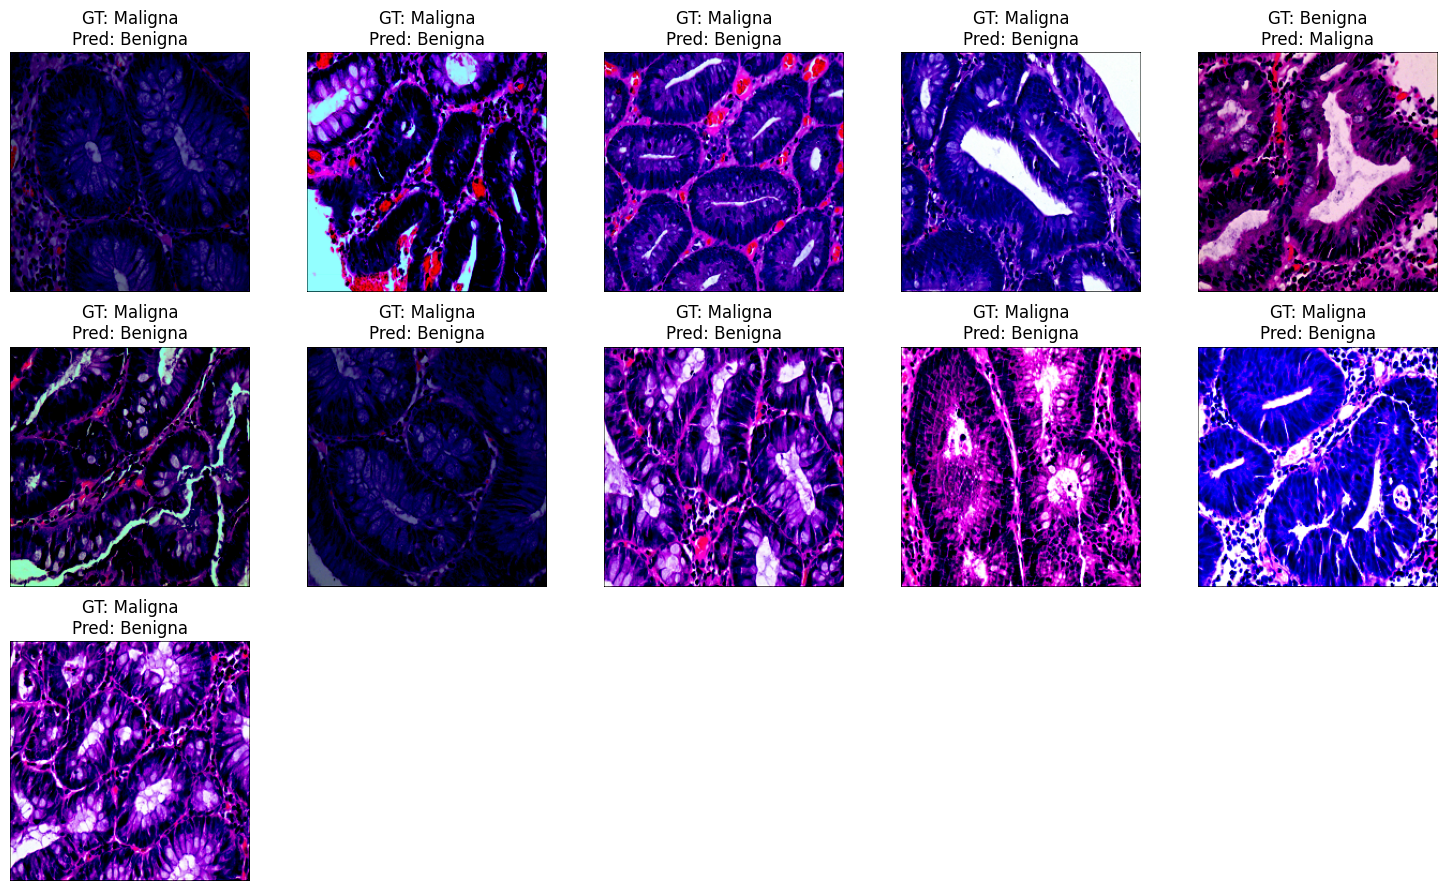

Total errores en validación: 11 / 446


In [11]:
import matplotlib.pyplot as plt
from torch.nn.functional import cosine_similarity, softmax
import torch

model.eval()
model.to(device)

wrong_imgs, wrong_gt, wrong_pred = [], [], []

for img, label in val_dataset:
    img_tensor = img.unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model(img_tensor).last_hidden_state[:,0]

    # k-NN top-3
    class0_feats = train_features[train_labels==0].to(device)
    class1_feats = train_features[train_labels==1].to(device)

    sims0 = cosine_similarity(emb, class0_feats)
    sims1 = cosine_similarity(emb, class1_feats)

    topk = 7
    topk0 = sims0.topk(topk).values.mean()
    topk1 = sims1.topk(topk).values.mean()

    prob = softmax(torch.stack([topk0, topk1]), dim=0)
    pred_class = torch.argmax(prob).item()

    # Guardar solo si hay error
    if pred_class != label:
        wrong_imgs.append(img)
        wrong_gt.append(label)
        wrong_pred.append(pred_class)

# --- Mostrar todas las equivocaciones ---
n_wrong = len(wrong_imgs)
cols = 5
rows = (n_wrong + cols - 1) // cols

plt.figure(figsize=(3*cols, 3*rows))
for i, (img, gt, pred) in enumerate(zip(wrong_imgs, wrong_gt, wrong_pred)):
    plt.subplot(rows, cols, i+1)
    plt.imshow(img.permute(1,2,0).cpu())
    plt.axis('off')
    plt.title(f"GT: {'Benigna' if gt==0 else 'Maligna'}\nPred: {'Benigna' if pred==0 else 'Maligna'}")
plt.tight_layout()
plt.show()

print(f"Total errores en validación: {n_wrong} / {len(val_dataset)}")